<a href="https://colab.research.google.com/github/spazewalker/FER_Doggomaniacs/blob/master/Emotion_Recognition(Pre_processing)FER2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Haar cascades.

In [1]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml

--2020-07-09 15:42:55--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341406 (333K) [text/plain]
Saving to: ‘haarcascade_eye.xml.2’

haarcascade_eye.xml 100%[===================>] 333.40K  --.-KB/s    in 0.06s   

2020-07-09 15:42:55 (5.01 MB/s) - ‘haarcascade_eye.xml.2’ saved [341406/341406]



In [2]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

--2020-07-09 15:43:00--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml.2’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.09s   

2020-07-09 15:43:00 (9.65 MB/s) - ‘haarcascade_frontalface_default.xml.2’ saved [930127/930127]



# Importing Packages.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [3]:
import cv2
import csv
from math import sqrt
import scipy.misc
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
eye_cascade = cv2.CascadeClassifier('/content/haarcascade_eye.xml')
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')
emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Loading Data.
Change the location of zip file.

Loading csv file.

In [ ]:
data = pd.read_csv("/content/drive/My Drive/FER/fer2013.zip",compression = 'zip',sep = ',')

Loading Y part

In [ ]:
y = np.array(data['emotion'])
print(y)
y = [y]
y = np.array(y)
y= y.T

[0 0 2 ... 0 3 2]


In [ ]:
print(y.shape)

(35887, 1)


#Preprocessing Starts here.

Converting the array of pixels to image.
1. Converted to a numpy array
2. Then resized to higher dimension for processing.

In [34]:
def modification(image):
  image = np.mat(image).reshape(48, 48,1) 
  image = np.uint8(image)
  image = cv2.resize(image,(480,480), interpolation = cv2.INTER_AREA)
  return image

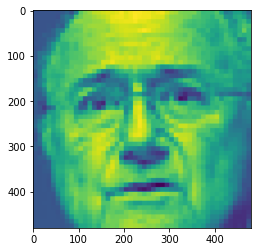

In [ ]:
image  = modification(data['pixels'][5])
plt.imshow(image)
plt.show()

Rotation:
1. Finding the face and then eye using Haar cascades.
2. Upon detection, finding the angle made by line joining the eyes and horizontal.
3. Then transformation matrix if found.
4. Finally cropping is done.

In [4]:
def rotate(image):
  l1=[]
  faces = face_cascade.detectMultiScale(image)
  if(len(faces)==1):
    for (x,y,w,h) in faces:
      face_detected = image[y:y+h,x:x+h]
      eyes = eye_cascade.detectMultiScale(face_detected)
      for (ex,ey,ew,eh) in eyes:
          l1.append((ex+ew/2,ey+eh/2))
      
      if(len(l1)==2):
        dist_x = l1[1][0]-l1[0][0]
        dist_y = l1[1][1] - l1[0][1]
        if dist_x<0:
          dist_y = -dist_y
        dist_x = np.abs(dist_x)     
        angle = np.arctan(dist_y/dist_x) * 180/3.14
        M = cv2.getRotationMatrix2D((240, 240), angle, 1.0)
        image = cv2.warpAffine(image, M,(480,480))
  return image

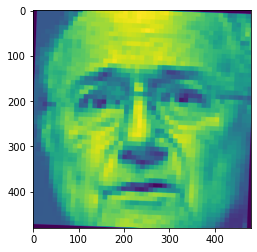

In [ ]:
image = rotate(image)
plt.imshow(image)
plt.show()

Cropping:
1. Face is detected and then image is cropped to the face detected.
2. Now, eyes are detected and the distance between them is calculated.
3. Using x_factor and y_factor with distance, crop the image.

In [5]:
def crop(image,x_factor=2.1,y_factor=3.2):
  l1=[]
  faces = face_cascade.detectMultiScale(image)
  if(len(faces)==1):
    for (x,y,w,h) in faces:
      image = image[y:y+h,x:x+h]

  eyes = eye_cascade.detectMultiScale(image)
  for (ex,ey,ew,eh) in eyes:
      l1.append((ex+ew/2,ey+eh/2))
  if(len(l1)==2):
    dist = np.sqrt((l1[0][0]-l1[1][0])**2+(l1[0][1]-l1[1][1])**2)
    center_x = image.shape[1]//2
    center_y = image.shape[0]//2
    shift_x = int(dist*x_factor)//2
    shift_y = int(dist*y_factor)//2
    start_x = center_x - shift_x
    start_x = max(start_x,0)
    end_x = center_x+shift_x
    end_x = min(end_x,image.shape[1])
    start_y = center_y - shift_y
    start_y = max(start_y,0)
    end_y = center_y + shift_y
    end_y = min(end_y,image.shape[0])
    image = image[start_y:end_y,start_x:end_x]
  return image

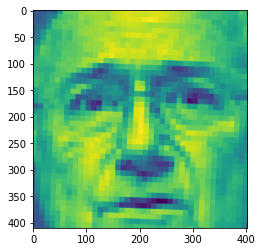

In [ ]:
image = crop(image)
plt.imshow(image)
plt.show()

In [6]:
def preProcessing(images,x_factor=2.1,y_factor=3.2):
  x_images= []
  for i in images:
    image = i
    image = modification(image)
    image = rotate(image)
    image = crop(image,x_factor,y_factor)
    #Smoothing
    image = cv2.bilateralFilter(image, 4, 15, 15)
    #Resizing
    image = cv2.resize(image,(48,48), interpolation = cv2.INTER_AREA)
    x_images.append(image)
  x_images= np.array(x_images)
  return x_images


In [ ]:
x = preProcessing(data['pixels'])

To show the progress.

In [ ]:
def progress(percent=0, width=30):
  left = int(width * percent) // 100
  right = width - left
  print('\r[', '#' * left, ' ' * right, ']',
        f' {percent:.2f}%',
        sep='', end='', flush=True)

Since preprocessing takes too much time. It is beneficial to save the preprocessed data in for of CSV and then use it when required. This function do the same.

In [ ]:
def savePreprocessed(data,x_factor=2.1,y_factor=3.2):
  images = data['pixels']
  y = np.array(data['emotion'])
  x_images= []
  y_emotion = []
  total = images.shape[0]
  for i in range(total):
    progress(i*100/total)
    image = images[i]
    image = modification(image)
    # plt.imshow(image)
    # plt.show()
    image = rotate(image)
    image = crop(image,x_factor,y_factor)
    #Smoothing
    image = cv2.bilateralFilter(image, 4, 15, 15)
    #Resizing
    image = cv2.resize(image,(48,48), interpolation = cv2.INTER_AREA)
    flattened = image.flatten()
    flattened = list(flattened)
    flattened = ' '.join(map(str, flattened))
    x_images.append(flattened)
    y_emotion.append(y[i])
  data1 = {'emotion':y_emotion,'pixels':x_images}
  df = pd.DataFrame(data1)
  df.to_csv('/content/sample_data/preprocessed.csv',index = False)
  return

In [ ]:
savePreprocessed(data[0:100])

[############################# ] 99.00%

In [10]:
def get_faces(image,x_factor=2.1,y_factor=3.2):
  height,width,_ = image.shape
  factor = 720/height
  image = cv2.resize(image,(int(width*factor),int(height*factor)),interpolation = cv2.INTER_AREA)
  faces = face_cascade.detectMultiScale(image)
  face_list = []
  labels = []
  for (x,y,w,h) in faces:
    x  = x - int(0.2*w)
    y = y - int(0.2*h)
    w = int(1.2*w)
    h = int(1.2*w)
    face = image[y:y+h,x:x+h]
    face = rotate(face)
    face = crop(face,x_factor,y_factor)
    #Smoothing
    face = cv2.bilateralFilter(face, 4, 15, 15)
    #Resizing
    face = cv2.resize(face,(48,48), interpolation = cv2.INTER_AREA)
    face_list.append(face)
    labels.append((int(x/factor),int(y/factor)))
  return face_list,labels 

In [ ]:
image = plt.imread("/content/sample_data/person2.jpeg")
faces,labels = get_faces(image)
#labels is if you want to label each face with emotion.
for face,label in zip(faces,labels):
  plt.imshow(face)
  plt.show()
  print(label)

# Dividing Data between train,dev,test.

In [ ]:
def partition(x,y):
  size = y.shape[0]
  sizetrain = (8*size)//10
  size2 = (10*size)//100
  order=np.random.permutation(size)
  x=x[order]
  y=y[order]
  train_x = x[0:sizetrain]
  train_y = y[0:sizetrain]
  dev_x = x[sizetrain:sizetrain+size2]
  dev_y = y[sizetrain:sizetrain+size2]
  test_x = x[sizetrain+size2:size]
  test_y = y[sizetrain+size2:size]
  return train_x,train_y,dev_x,dev_y,test_x,test_y

# Class Implementation
Currently this is not working.

In [ ]:
class PreProcessing:
  def __init__(self,images,x_factor = 2.1,rotate = True, crop = True, smoothing = True, resize = True, y_factor = 3.2,smoothing_params=(4, 15, 15),resize_shape=(48,48)):
    self.images = images
    self.total = images.shape[0]
    self.face = 0
    self.eye = 0
    self.face_count = 0
    self.eye_count = 0
    self.image = 0
    self.face_detected = 0
    self.eye_detected = 0
    self.rotate_state = True
    self.crop_state =True
    self.smoothing_state = True
    self.resize_state = True
    self.x_factor = x_factor
    self.y_factor = y_factor
    self.smoothing_params = smoothing_params
    self.resize_shape = resize_shape

  def modification(self,image):
    image = np.mat(image).reshape(48,48,1)
    image = np.uint8(image)
    image = cv2.resize(image,(480,480), interpolation = cv2.INTER_AREA)
    self.image = image
  def detection(self):
    faces = face_cascade.detectMultiScale(self.image)
    if(len(faces)==1):
      self.face = 1
      self.face_count+=1
      for (x,y,w,h) in faces:
        self.face_detected = self.image[y:y+h,x:x+h]
        eyes = eye_cascade.detectMultiScale(self.face_detected)
        for (ex,ey,ew,eh) in eyes:
          l1.append((ex+ew/2,ey+eh/2))
        if(len(l1)==2):
          self.eye = 1
          self.eye_count+=1
          self.eye_detected = l1
        else:
          self.eye = 0
    else:
      self.face = 0
  
  def rotation(self):
    self.detection()
    if self.eye == 1:
      dist_x = self.eye_detected[1][0]-self.eye_detected[0][0]
      dist_y = self.eye_detected[1][1] - self.eye_detected[0][1]
      if dist_x<0:
        dist_y = -dist_y
      dist_x = np.abs(dist_x)
      angle = np.arctan(dist_y/dist_x) * 180/3.14
      M = cv2.getRotationMatrix2D((240, 240), angle, 1.0)
      self.image = cv2.warpAffine(self.image, M,(480,480))
  def crop(self):
    self.detection()
    if self.face == 1:
      self.image = self.face_detected
      if self.eye ==1:
        dist = np.sqrt((self.eye_detected[0][0]-self.eye_detected[1][0])**2+(self.eye_detected[0][1]-self.eye_detected[1][1])**2)
        center_x = self.image.shape[1]//2
        center_y = self.image.shape[0]//2
        shift_x = int(dist*self.x_factor)//2
        shift_y = int(dist*self.y_factor)//2
        start_x = center_x - shift_x
        start_x = max(start_x,0)
        end_x = center_x+shift_x
        end_x = min(end_x,self.image.shape[1])
        start_y = center_y - shift_y
        start_y = max(start_y,0)
        end_y = center_y + shift_y
        end_y = min(end_y,self.image.shape[0])
        self.image = self.image[start_y:end_y,start_x:end_x]
  def smoothing(self):
    self.image = cv2.bilateralFilter(self.image, self.smoothing_params[0], self.smoothing_params[1], self.smoothing_params[2])
  

  def resize(self):
    self.image = cv2.resize(self.image,self.resize_shape, interpolation = cv2.INTER_AREA)
  def getImage(self):
    return self.image
  def summary(self):
    print("Total Images:",self.total)
    if (self.rotate_state==True and self.crop_state==True):
      print("Total Face Detected: ",self.face_count//2)
      print("Total Eye Detected:",self.eye_count//2)
    else:
      print("Total Face Detected: ",self.face_count)
      print("Total Eye Detected:",self.eye_count)
  
  def main(self):
    x=[]
    for i in self.images:
      self.modification(i)
      plt.imshow(self.image)
      plt.show()
      if self.rotate_state==True:
        self.rotation()
      print("After rotation")
      plt.imshow(self.image)
      plt.show()
      if self.crop_state == True:
        self.crop()
      print("After cropping")
      plt.imshow(self.image)
      plt.show()
      if self.smoothing_state == True:
        self.smoothing()
      print("After smoothing")
      plt.imshow(self.image)
      plt.show()
      if self.resize_state ==True:
        self.resize()
      print("After resizing")
      plt.imshow(self.image)
      plt.show()
      x.append(self.image)
    x = np.array(x)
    return x
